# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
100% 235k/235k [00:00<00:00, 571kB/s]
100% 235k/235k [00:00<00:00, 571kB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [4]:
!pip install mplfinance
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00


In [5]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import KNNImputer

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from statsmodels.tsa.seasonal import seasonal_decompose

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [6]:
df = pd.read_csv('/content/Traffic Data.csv')


In [7]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

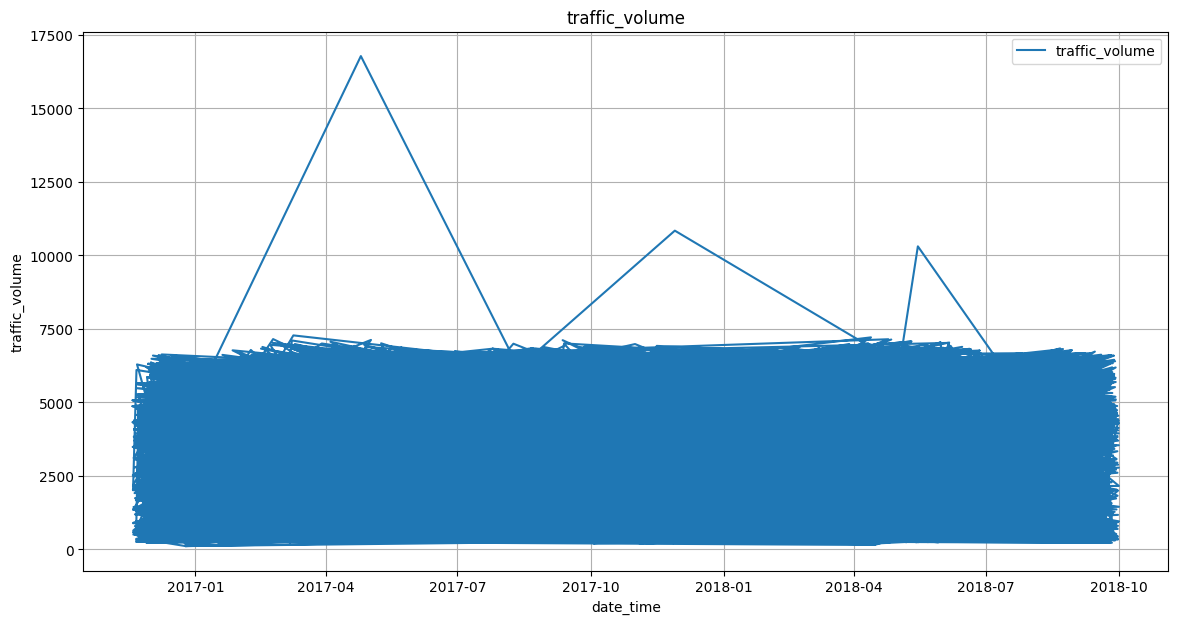

In [8]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)
# رسم السلسلة الزمنية
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['traffic_volume'], label='traffic_volume')
plt.title('traffic_volume')
plt.xlabel('date_time')
plt.ylabel('traffic_volume')
plt.legend()
plt.grid(True)
plt.show()

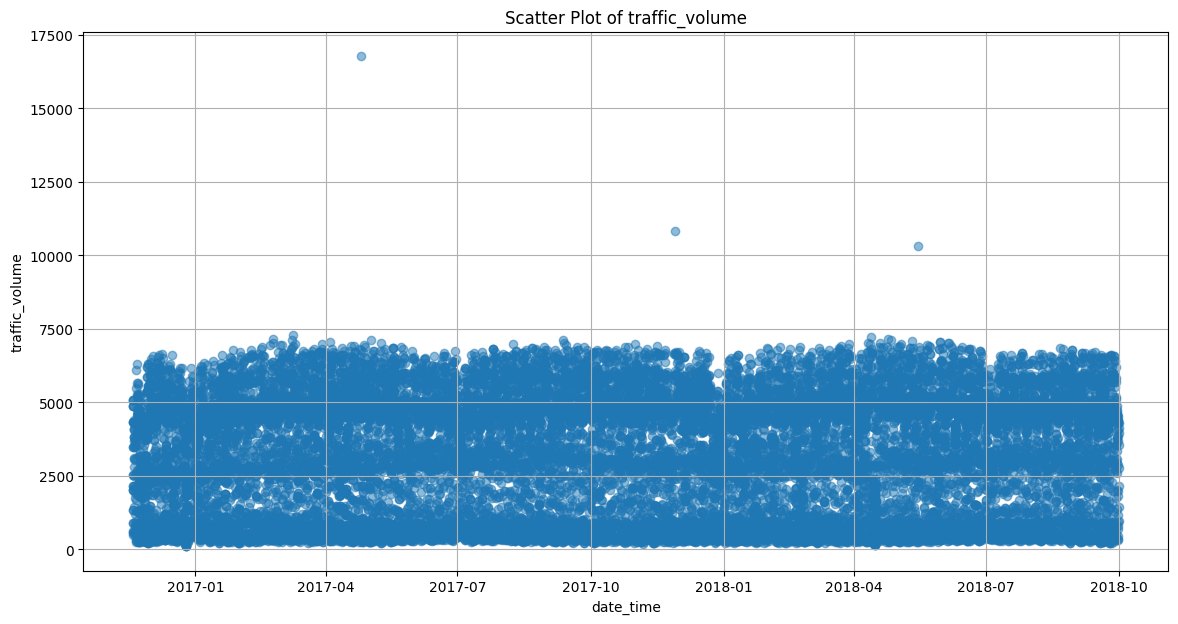

In [12]:
plt.figure(figsize=(14, 7))
plt.scatter(df.index, df['traffic_volume'], alpha=0.5)
plt.title('Scatter Plot of traffic_volume')
plt.xlabel('date_time')
plt.ylabel('traffic_volume')
plt.grid(True)
plt.show()

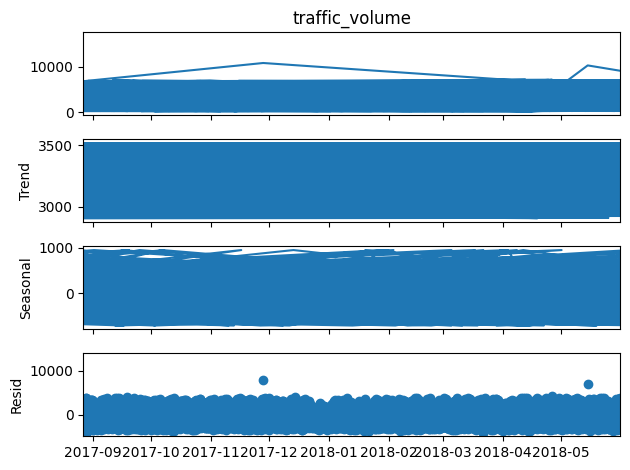

In [18]:
decomposition = seasonal_decompose(df['traffic_volume'], model='additive', period=365)

# رسم trend- Seasonal- resid
decomposition.plot()
plt.show()

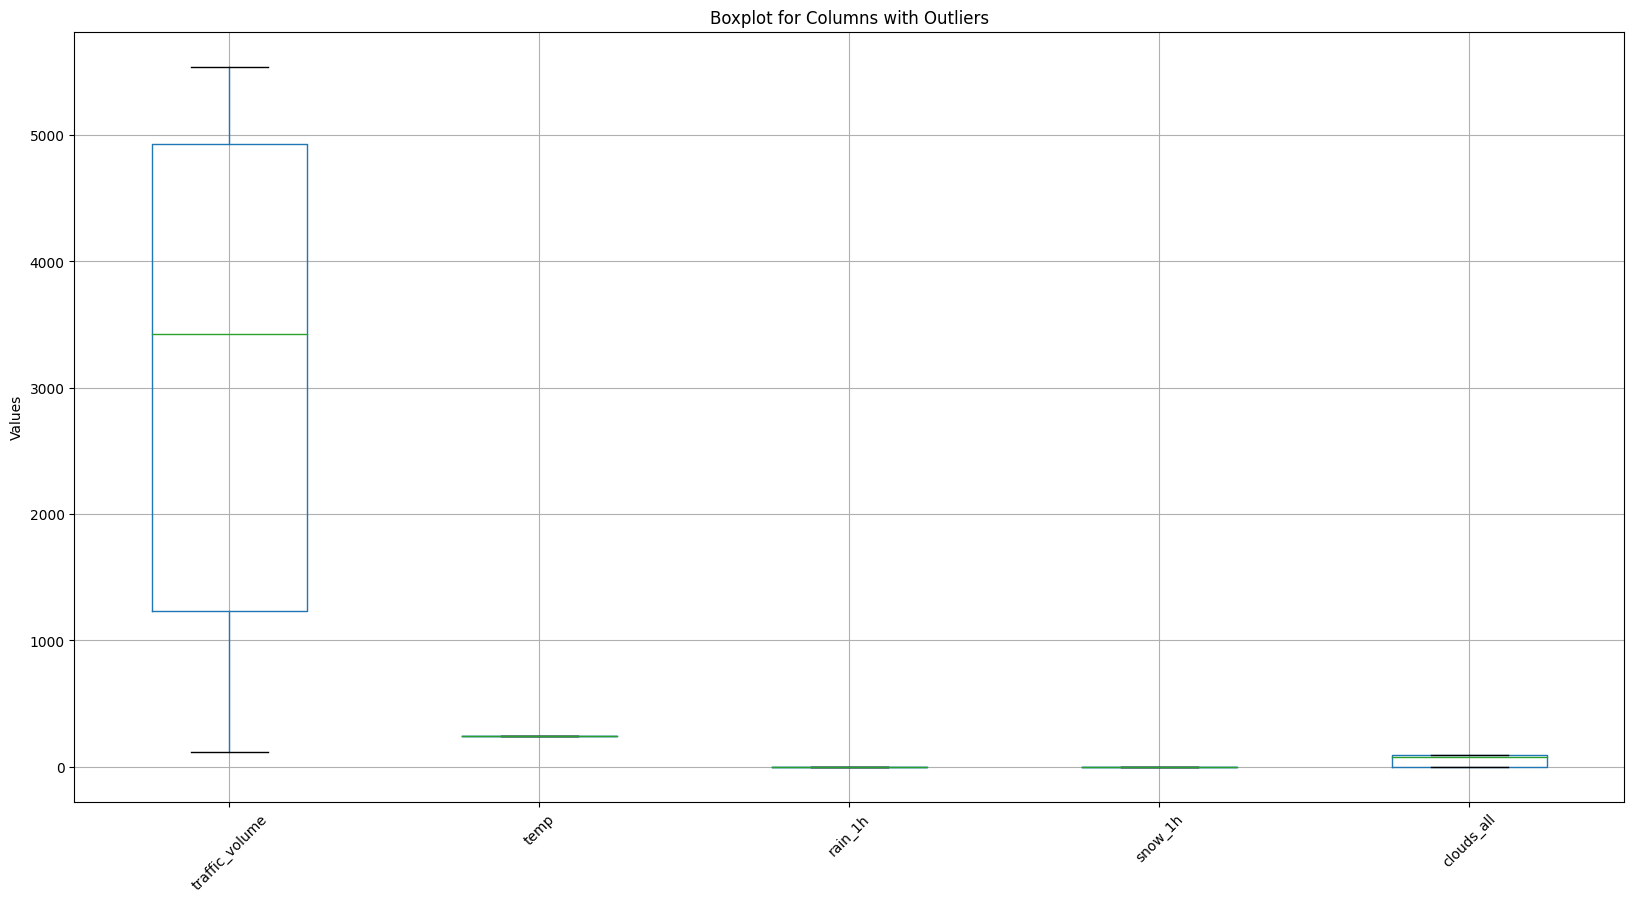

In [21]:
col_with_outliers = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',]

plt.figure(figsize=(20, 10))
df[col_with_outliers].boxplot()

plt.title('Boxplot for Columns with Outliers')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

In [22]:
for col in col_with_outliers:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower = Q1-1.5*IQR
  upper = Q3=1.5 * IQR
  df[col] = df[col].clip(lower, upper)

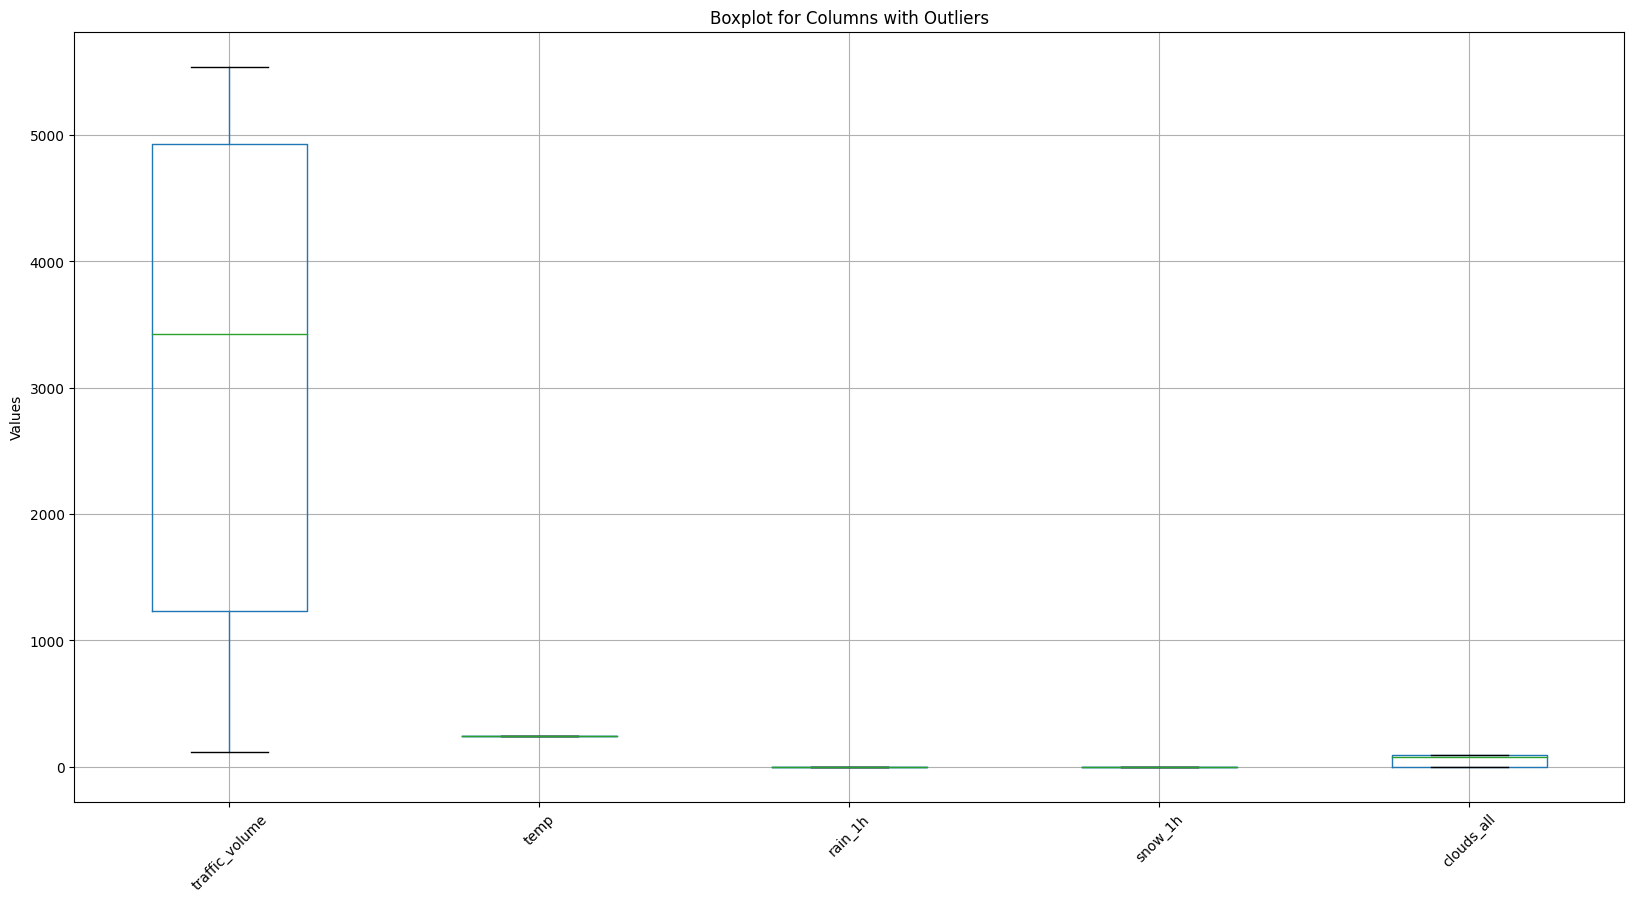

In [23]:
col_with_outliers =  ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',]

plt.figure(figsize=(20, 10))
df[col_with_outliers].boxplot()

plt.title('Boxplot for Columns with Outliers')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

In [45]:
for col in df:
  print(df[col].unique())
  print('-----------------------------------')

[ nan   0. 202. ... 827. 880. 819.]
-----------------------------------
[242.115]
-----------------------------------
[0.]
-----------------------------------
[0.]
-----------------------------------
[90. 40.  1. 75. 20.  5. 64. 80. 76.  0.  8. 12. 32. 68. 92. 88. 24. 36.
 48. 44. 56.]
-----------------------------------
['Fog' 'Mist' 'Snow' 'Haze' 'Clouds' 'Clear' 'Rain' 'Drizzle'
 'Thunderstorm' 'Smoke']
-----------------------------------
['fog' 'mist' 'heavy snow' 'light snow' 'haze' 'overcast clouds'
 'sky is clear' 'broken clouds' 'scattered clouds' 'few clouds'
 'light rain' 'moderate rain' 'light intensity drizzle' 'snow'
 'freezing rain' 'shower drizzle' 'drizzle' 'proximity thunderstorm'
 'heavy intensity rain' 'proximity shower rain' 'thunderstorm'
 'light shower snow' 'Sky is Clear' 'sleet' 'thunderstorm with heavy rain'
 'heavy intensity drizzle' 'light rain and snow'
 'thunderstorm with light rain' 'proximity thunderstorm with rain'
 'thunderstorm with light drizzle' 'pro

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [14]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [16]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description'],
      dtype='object')

In [17]:
numeric_cols = ['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all']# اخترت الاعمدة التى تكون قيمتها ارقام
# KNN for Numeric واستخدمت الKNNمن اجل مل القيم المفقودة
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [31]:
df.sort_values('date_time', inplace=True)
df['traffic_volume'] = df['traffic_volume'].shift(1)
df.dropna(inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19999 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19998 non-null  float64
 1   temp                 19999 non-null  float64
 2   rain_1h              19999 non-null  float64
 3   snow_1h              19999 non-null  float64
 4   clouds_all           19999 non-null  float64
 5   weather_main         19999 non-null  object 
 6   weather_description  19999 non-null  object 
 7   Day_of_Week          19999 non-null  int32  
 8   Month                19999 non-null  int32  
 9   Day_of_Year          19999 non-null  int32  
 10  IsWeekend            19999 non-null  bool   
 11  Year                 19999 non-null  int32  
dtypes: bool(1), float64(5), int32(4), object(2)
memory usage: 1.5+ MB


In [49]:
df.shape

(19999, 12)

In [50]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['weather_description'] = encoder.fit_transform(df['weather_description'])
df['weather_main'] = encoder.fit_transform(df['weather_main'])


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19999 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19998 non-null  float64
 1   temp                 19999 non-null  float64
 2   rain_1h              19999 non-null  float64
 3   snow_1h              19999 non-null  float64
 4   clouds_all           19999 non-null  float64
 5   weather_main         19999 non-null  int64  
 6   weather_description  19999 non-null  int64  
 7   Day_of_Week          19999 non-null  int32  
 8   Month                19999 non-null  int32  
 9   Day_of_Year          19999 non-null  int32  
 10  IsWeekend            19999 non-null  bool   
 11  Year                 19999 non-null  int32  
dtypes: bool(1), float64(5), int32(4), int64(2)
memory usage: 1.5 MB


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [32]:
df['Day_of_Week'] = df.index.dayofweek  # أيام الأسبوع (0 = الاثنين، 6 = الأحد)
df['Month'] = df.index.month  # الأشهر (1 = يناير، 12 = ديسمبر)
df['Day_of_Year'] = df.index.dayofyear  # ايام السنة
df['IsWeekend'] = df.index.dayofweek >= 5  # 1 إذا كانت عطلة نهاية الأسبوع، 0 خلاف ذلك
df["Year"]= df.index.year

In [33]:
df['traffic_volume'] = df['traffic_volume'].diff()

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [53]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [46]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'Day_of_Week', 'Month',
       'Day_of_Year', 'IsWeekend', 'Year'],
      dtype='object')

In [74]:
scaler = MinMaxScaler()

train_data_scaled = scaler.fit_transform(train)
test_data_scaled = scaler.transform(test)

In [69]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(15939, 60, 1)
(15939,)


Testing set size:-
(3940, 60, 1)
(3940,)


(None, None)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
# model 1 is RNN

In [75]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [84]:
model = Sequential()

model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
model.compile(loss='mean_squared_error',  metrics=['accuracy'],optimizer='adam')

In [86]:
history = model.fit(X_test, y_test, epochs=10, batch_size=72,
                    validation_data=(X_test, y_test), verbose=2,
                    shuffle=False)

Epoch 1/10
55/55 - 8s - 150ms/step - accuracy: 0.1170 - loss: 430296.4688 - val_accuracy: 0.0975 - val_loss: 428212.7500
Epoch 2/10
55/55 - 4s - 64ms/step - accuracy: 0.1028 - loss: 427328.2188 - val_accuracy: 0.0972 - val_loss: 426134.4688
Epoch 3/10
55/55 - 5s - 96ms/step - accuracy: 0.1036 - loss: 425305.4688 - val_accuracy: 0.0987 - val_loss: 424258.7500
Epoch 4/10
55/55 - 8s - 154ms/step - accuracy: 0.1030 - loss: 423372.9688 - val_accuracy: 0.1020 - val_loss: 422235.6875
Epoch 5/10
55/55 - 6s - 110ms/step - accuracy: 0.1025 - loss: 421602.8438 - val_accuracy: 0.1023 - val_loss: 420589.2812
Epoch 6/10
55/55 - 4s - 77ms/step - accuracy: 0.1020 - loss: 419826.1250 - val_accuracy: 0.1020 - val_loss: 418958.5000
Epoch 7/10
55/55 - 6s - 113ms/step - accuracy: 0.1023 - loss: 418382.9375 - val_accuracy: 0.1023 - val_loss: 417387.8438
Epoch 8/10
55/55 - 4s - 71ms/step - accuracy: 0.1023 - loss: 416732.2812 - val_accuracy: 0.1023 - val_loss: 415886.8438
Epoch 9/10
55/55 - 5s - 92ms/step - 

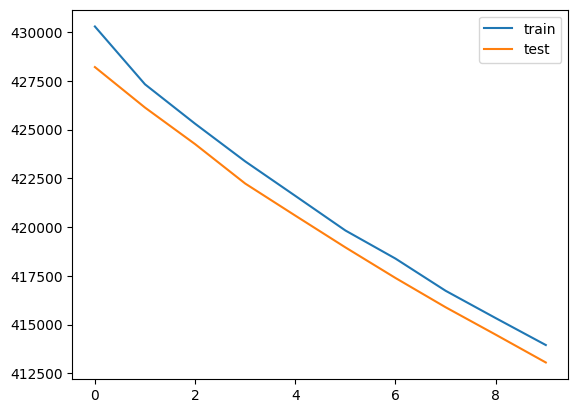

In [87]:
# Plot the training loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [100]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


499/499 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [105]:
train_Score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_Score))
test_Score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_Score))

ValueError: Found input variables with inconsistent numbers of samples: [60, 15939]

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

model 2 is LSTM


In [88]:
model = Sequential()
model.add(LSTM(50, activation='relu',
               input_shape=(X_train.shape[1], X_train.shape[2]),
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
model.compile(loss='mean_squared_error',  metrics=['accuracy'],optimizer='adam')

In [92]:
history = model.fit(X_test, y_test, epochs=10, batch_size=16,
                    validation_data=(X_test, y_test), verbose=2,
                    shuffle=False)

Epoch 1/10
44/44 - 5s - 110ms/step - accuracy: 0.0713 - loss: 432372.5312 - val_accuracy: 0.0462 - val_loss: 432364.9062
Epoch 2/10
44/44 - 7s - 161ms/step - accuracy: 0.0662 - loss: 432373.4375 - val_accuracy: 0.0424 - val_loss: 432363.8125
Epoch 3/10
44/44 - 5s - 108ms/step - accuracy: 0.0624 - loss: 432381.2812 - val_accuracy: 0.0414 - val_loss: 432375.5625
Epoch 4/10
44/44 - 5s - 111ms/step - accuracy: 0.0599 - loss: 432387.0312 - val_accuracy: 0.0447 - val_loss: 432377.5312
Epoch 5/10
44/44 - 6s - 144ms/step - accuracy: 0.0584 - loss: 432362.0312 - val_accuracy: 0.0497 - val_loss: 432392.3438
Epoch 6/10
44/44 - 10s - 236ms/step - accuracy: 0.0607 - loss: 432363.2812 - val_accuracy: 0.0414 - val_loss: 432383.2188
Epoch 7/10
44/44 - 9s - 196ms/step - accuracy: 0.0685 - loss: 432372.7812 - val_accuracy: 0.0475 - val_loss: 432378.8125
Epoch 8/10
44/44 - 7s - 155ms/step - accuracy: 0.0685 - loss: 432370.7500 - val_accuracy: 0.0320 - val_loss: 432369.5312
Epoch 9/10
44/44 - 9s - 196ms/s

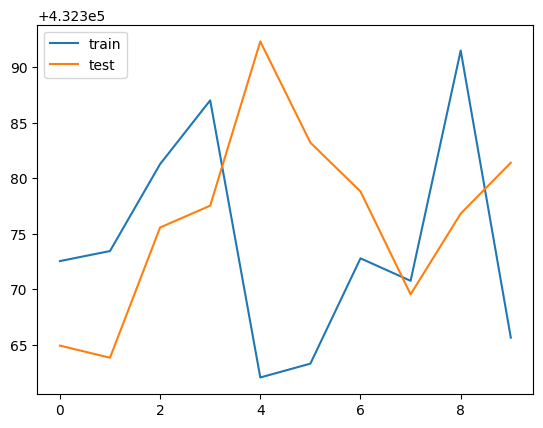

In [93]:
# Plot the training loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [94]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

499/499 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [108]:
# train_Score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
# print('Train Score: %.2f RMSE' % (train_Score))
# test_Score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
# print('Test Score: %.2f RMSE' % (test_Score))

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here: